In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from jupyterplot import ProgressPlot 
from matplotlib.animation import FuncAnimation

import copy
import numpy as np
import time
from collections import deque, OrderedDict
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from timeit import default_timer as timer

def timer_func(func):
    def wrapper(*args, **kwargs):
        t1 = timer()
        result = func(*args, **kwargs)
        t2 = timer()
        print(f'{func.__name__}() executed in {(t2-t1):.6f}s')
        return result
    return wrapper

In [3]:
class DQN():
    def __init__(
            self,
            env,
            gamma,
            epsilon,
            numEpisodes,
            stateDim,
            actionDim,
            replayBufferSize,
            batchSize,
            targetUpdateFrequency,
            epsilonDecay,
            epsilonDecayStart,
            tau,
            lr,
            numSteps
    ):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.numEpisodes = numEpisodes
        self.stateDim = stateDim
        self.actionDim = actionDim
        self.replayBufferSize = replayBufferSize
        self.batchSize = batchSize
        self.targetUpdateFrequency = targetUpdateFrequency
        self.epsilonDecay = epsilonDecay
        self.epsilonDecayStart = epsilonDecayStart
        self.tau = tau
        self.numSteps = numSteps

        self.counterSinceLastUpdate = 0
        self.sumRewardsEpisode = []

        self.replayBuffer = deque(maxlen=self.replayBufferSize)

        self.network = self.createNetwork(self.stateDim, self.actionDim)

        self.actionsHistory = []

        self.optim = torch.optim.Adam(self.network.parameters(), lr=lr)

    def createNetwork(self, inDim, outDim):
        return nn.Sequential(
            nn.Linear(inDim, 64),
            nn.ReLU(),
            # nn.Dropout(0.4),
            
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.Dropout(0.4),

            nn.Linear(64, 32),
            nn.ReLU(),
            # nn.Dropout(0.4),

            nn.Linear(32, outDim),
        ).to(device)
    
    def my_loss(self, y_pred, y_true):
        s1,s2=y_true.shape
        # if self.counterSinceLastUpdate%200==0:
        #     print(f"y_true: {y_true}")
        #     print(f"y_pred: {y_pred}")
        #     print(f"actions: {self.actionsHistory}")
        #     print(f"selected: {y_pred[torch.arange(s1), self.actionsHistory]}")
        loss = F.mse_loss(y_pred[torch.arange(s1), self.actionsHistory], y_true[torch.arange(s1), self.actionsHistory])
       
        return loss    
    
    def trainingEpisodes(self):
        self.sumRewardsEpisode = []
        self.avgQ = []
        self.fig, self.ax = plt.subplots(2, 1, figsize=(7, 5))
        for idx in tqdm(range(self.numEpisodes)):
            rewards = []
            (currentState, _) = self.env.reset()
            terminalState = False
            print(f"Total steps: {self.counterSinceLastUpdate}")
            self.Qs = []
            while not terminalState:
                # start_time = time.time()
                action = self.selectAction(currentState, idx)
                # print(f"selectAction took {time.time() - start_time} seconds")
                
                # start_time = time.time()
                (nextState, reward, terminalState, _, _) = self.env.step(action)
                # print(f"env.step took {time.time() - start_time} seconds")
                
                # start_time = time.time()
                rewards.append(reward)
                # print(f"Appending rewards took {time.time() - start_time} seconds")
                
                # start_time = time.time()
                self.replayBuffer.append((currentState, action, reward, nextState, terminalState))
                # print(f"Appending to replay buffer took {time.time() - start_time} seconds")
                
                # start_time = time.time()
                self.trainNetwork()
                # print(f"trainNetwork took {time.time() - start_time} seconds")
                
                # start_time = time.time()
                currentState = nextState
                # print(f"Updating currentState took {time.time() - start_time} seconds")
            
            self.sumRewardsEpisode.append(np.sum(rewards))
            self.avgQ.append(np.mean(self.Qs))
            # start_time = time.time()
            self.ax[0].clear()
            self.ax[1].clear()
            self.ax[0].plot(self.sumRewardsEpisode, label='Sum Rewards')
            self.ax[0].set_title('Sum Rewards Episode')
            self.ax[1].plot(self.avgQ, label='Average Q')
            self.ax[1].set_title('Average Q')
            self.ax[0].legend()
            self.ax[1].legend()
            plt.tight_layout()

            clear_output(wait=True)
            display(self.fig)
            # print(f"Updating plot took {time.time() - start_time} seconds")

            
    
    def selectAction(self, state, index):
        if index == 0:
            return np.random.choice(self.actionDim)
        
        rand = np.random.random()
        if index > self.epsilonDecayStart:
            self.epsilon *= self.epsilonDecay

        if rand < self.epsilon:
            return np.random.choice(self.actionDim)
        
        Q = self.network(torch.tensor(state.reshape(1, 4)).to(device))

        return torch.argmax(Q[0]).item()
    
    def trainNetwork(self):
        # start_time = time.time()
        if len(self.replayBuffer) > self.batchSize:
            # print(f"Checking replay buffer size took {time.time() - start_time} seconds")
            
            # start_time = time.time()
            randomBatch = random.sample(self.replayBuffer, self.batchSize)
            # print(f"Sampling from replay buffer took {time.time() - start_time} seconds")

            # start_time = time.time()
            currentStateBatch = torch.zeros(size=(self.batchSize, 4)).to(device)
            nextStateBatch = torch.zeros(size=(self.batchSize, 4)).to(device)
            # print(f"Initializing tensors took {time.time() - start_time} seconds")

            # start_time = time.time()
            for index, tupleS in enumerate(randomBatch):
                currentStateBatch[index, :] = torch.tensor(tupleS[0])
                nextStateBatch[index, :] = torch.tensor(tupleS[3])
            # print(f"Setting tensor values took {time.time() - start_time} seconds")

            # start_time = time.time()
            self.network.eval()
            # print(f"Setting network to eval mode took {time.time() - start_time} seconds")
            
            # start_time = time.time()
            QS_ = self.network(nextStateBatch)
            # print(f"Computing network output took {time.time() - start_time} seconds")


            # start_time = time.time()
            
            Y = torch.zeros((self.batchSize, 2)).to(device)
            self.actionsHistory = []
            rewards_batch = []
            for idx, (currentState,action,reward,nextState,terminated) in enumerate(randomBatch):
                rewards_batch.append(reward)
                if terminated:
                    y = reward
                else:
                    y = reward + self.gamma * torch.max(QS_[idx])

                self.actionsHistory.append(action)
                Y[idx, action] = y
            # print(f"Actions: {self.actionsHistory}")
            # print(f"Rewards: {rewards_batch}")
            # print(f"torch.max(QS_, dim=1): {torch.max(QS_, dim=1)}")
            # print(f"Y: {Y}\n\n\n")
            # print(f"Setting Y values took {time.time() - start_time} seconds")

            # start_time = time.time()
            # print(f"Appending Q values took {time.time() - start_time} seconds")

            # start_time = time.time()
            self.network.train()
            # print(f"Setting network to train mode took {time.time() - start_time} seconds")

            # start_time = time.time()
            self.optim.zero_grad()
            # print(f"Zeroing gradients took {time.time() - start_time} seconds")

            # start_time = time.time()
            QS = self.network(currentStateBatch).to(device)
            # print(f"QS: {QS}")
            # print(f"Getting network output took {time.time() - start_time} seconds")

            # start_time = time.time()
            loss = self.my_loss(QS, Y)
            # print(f"Calculating loss took {time.time() - start_time} seconds")

            # start_time = time.time()
            loss.backward()
            # print(f"Backpropagation took {time.time() - start_time} seconds")

            # start_time = time.time()
            self.optim.step()
            # print(f"Optimizer step took {time.time() - start_time} seconds")
            self.Qs.append(QS.flatten().sum().item())

            # start_time = time.time()
            self.counterSinceLastUpdate += 1
            # print(f"Incrementing counter took {time.time() - start_time} seconds\n\n\n")
            

In [4]:
env = gym.make('CartPole-v1')

In [5]:
dqn = DQN(
    env=env,
    gamma=1,
    epsilon=0.1,
    numEpisodes=1000,
    stateDim=4,
    actionDim=2,
    replayBufferSize=256,
    batchSize=64,
    targetUpdateFrequency=30,
    epsilonDecay=0.99,
    epsilonDecayStart=200,
    tau=1,
    lr = 1e-3,
    numSteps=25
)

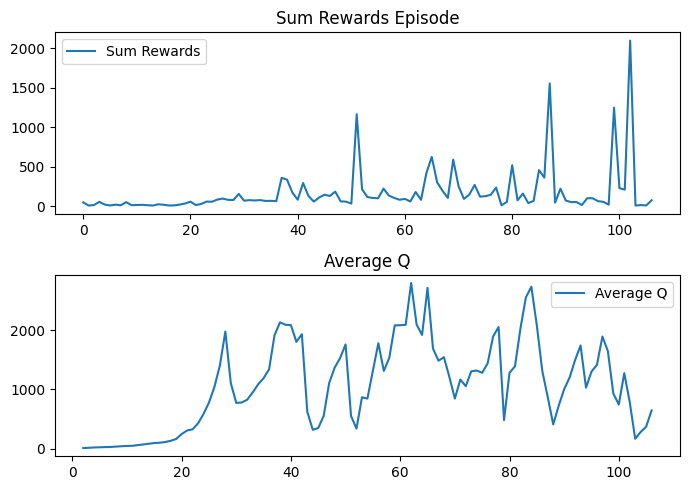

Total steps: 18134


KeyboardInterrupt: 

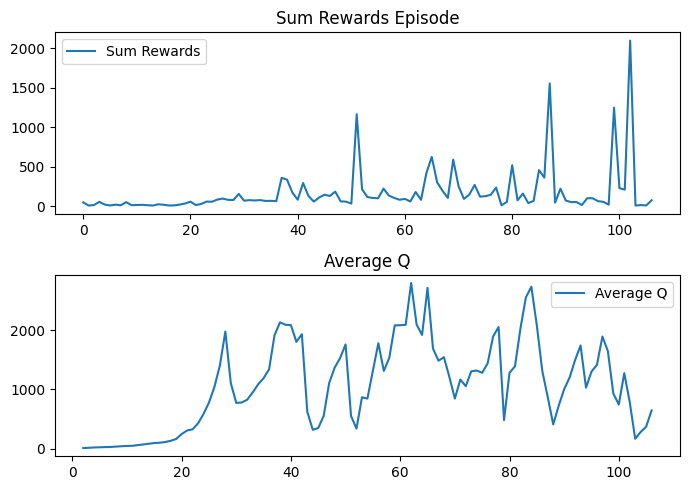

In [6]:
dqn.trainingEpisodes()

- git
- dropout
- clean, comment
- checkpoint
- tensorBoard
- .py
- params (yml)
- train, experiment
- use image
  - prepare dataset
  - train backbone
  - retrain 